# スコアの妥当性検証

## 次元性の仮定の検証

IRTでは、そのテストが測ろうとしている構成概念（スコア）の次元数を仮定してモデルを当てはめる。そのため、データがその仮定に合致するかを検討するというもの。

### スクリープロット

相関行列の固有値を降順に描いたプロット。

例えば第1成分から第2成分にかけて一気にカーブが下がってそれ以降はなだらかになっている（第1主成分だけで多くを説明できる）場合は1次元だとみなして妥当

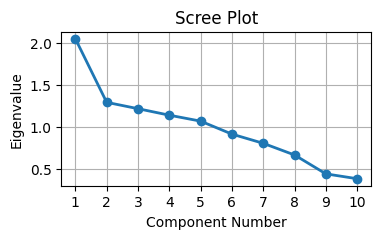

In [35]:
# ------------------------------
# サンプルデータの生成
# ------------------------------
import numpy as np
import pandas as pd

np.random.seed(42)

n_persons = 100
n_items = 10

# 能力θと項目困難度bを設定
theta = np.random.normal(0, 1, n_persons)
b = np.random.normal(0, 0.2, n_items)
a = np.random.normal(0, 0.1, n_items)

# 2PLMで応答を生成
prob = 1 / (1 + np.exp(- a * (theta[:, None] - b)))
responses = np.random.binomial(1, prob)

df = pd.DataFrame(responses, columns=[f"item_{i+1}" for i in range(n_items)])
# print(df.head())

# ------------------------------
# スクリープロット
# ------------------------------
import numpy as np
from ordinalcorr import hetcor

cor_matrix = hetcor(df)
eigenvalues, _ = np.linalg.eig(cor_matrix)
eigenvalues = np.sort(eigenvalues)[::-1]

import matplotlib.pyplot as plt
plt.figure(figsize=(4, 2))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', linewidth=2)
plt.title("Scree Plot")
plt.xlabel("Component Number")
plt.ylabel("Eigenvalue")
plt.xticks(range(1, len(eigenvalues) + 1))
plt.grid(True)
plt.show()

:::{info}

[Hattie, J. (1985). Methodology review: assessing unidimensionality of tests and ltenls. Applied psychological measurement, 9(2), 139-164.](https://journals.sagepub.com/doi/10.1177/014662168500900204)

は様々な次元性の検証方法の長短をレビューしている

:::

## 局所独立性の仮定の検証

**局所独立性（local independence）** とは、能力$\theta$を1つの値に固定したとき、各テスト項目への反応は互いに独立であるという性質。

言い換えると「項目間の相関は能力$\theta$という因子に起因していて、能力$\theta$を固定してその影響を除外（統制）すれば項目間の相関はない」という考え方。



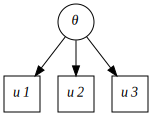

In [47]:
import graphviz
graphviz.Source("""
digraph g {
    graph [rankdir = TB];
    node[shape = circle];
        theta [label=<<I>θ</I>>]
    node[shape = square];
        u1    [label=<<I>u<SUB>1</SUB></I>>]
        u2    [label=<<I>u<SUB>2</SUB></I>>]
        u3    [label=<<I>u<SUB>3</SUB></I>>]
    edge [];
        theta -> {u1, u2, u3}
}
""")

局所独立性が満たされない場合はテスト情報量を過大評価するバイアスと、識別力パラメータの推定にバイアスが出ることが知られている。


また尤度関数が各項目のICCの積
$$
P(\mathbf{u} \mid \theta)=\prod_{j=1}^J P\left(u_j \mid \theta\right)
$$

で表せる理由も局所独立性のため

### $Q_3$統計量

$Q_3$統計量は局所独立性の検証に使われる統計量で、2つの項目のペアの残差の間の相関である。

:::{admonition} 項目ペアの$Q3$統計量

$Q_3$統計量は任意の項目のペア$j$と$j^\prime$について次のように定義される。

$$
Q_{3, j j^{\prime}} := r(d_j, d_{j^{\prime}})
$$

- $r(\cdot, \cdot)$：相関係数
- $d_{ij} := u_{ij} - \hat{P}_j(\hat{\theta}_i)$ ：推定したパラメータによるICC$\hat{P}_j(\hat{\theta}_i)$と項目反応$u_{ij}$の残差得点

:::

目安としては、「$|Q_3| \geq 0.20$の項目ペアは局所独立性の侵害を疑う必要がある」とされる

:::{admonition} テストの$Q3$統計量

実際には分析全体の評価に、その（絶対値の）最大値が使われる

$$
Q_{3, max} := \max_{j \neq j^{\prime}} Q_{3, j j^{\prime}}
$$

（$j = j^{\prime}$は相関行列の対角要素であり1になるので、それ以外の部分での最大値という意味）

:::

$Q_3$統計量は

- $\theta$によって項目間の相関関係が十分に説明されているとすれば、その影響を除去した残差得点同士の相関は0に近くなるはず
- $\theta$以外に項目間に相関をもたらす要因がある場合は$\theta$の影響を除いてもなお相関が残る

という考え方をとっている。


:::{card} $Q_3$統計量の短所（[Christensen et al., 2017](https://doi.org/10.1177/0146621616677520)）

- $Q_3$は平均がゼロではなく、ややマイナスに偏る負のバイアスが指摘されている（[Yen, 1984]( https://doi.org/10.1177/014662168400800201)）。
    - バイアスを補正したバージョン（単純にゼロで引く）も検討されている（[Christensen et al., 2017](https://doi.org/10.1177/0146621616677520)）
    - $Q_{3,*} := Q_{3, max} - \bar{Q_{3}}$
- 「$Q_3$がいくつ以下ならいい」という基準値が不明瞭（慣例的に0.2と言われがちだが実際の論文では0.3以下基準のものがあったり、まちまち）

:::

:::{admonition} とはいえ基準値は0.2でそんなにおかしくはなさそう

[Christensen et al. (2017)](https://doi.org/10.1177/0146621616677520) はシミュレーションした結果次のように述べている

- 「$Q_3$がいくつ以下ならいい」という基準値はデータセットにもよるし一概に言えない
- しかしシミュレーション上、平均の相関より0.2上回る（$Q_{3,*}\geq 0.2$）残差相関は局所依存を示唆する可能性があり、局所独立した項目の$Q_{3,*}$が0.3を超える可能性は低かった

:::



Q3の標本分布はわからないが、[Finch & Jeffers (2016)](https://pubmed.ncbi.nlm.nih.gov/29881045/) はpermutation testによりType I errorと検出率を推定する方法を提案している。



:::{card} Rでの推定例

Rだと `{mirt}` パッケージなどで推定できる

```r
model <- mirt(data, 1) # 1次元IRTのfit
residuals(model, type = 'Q3') # 残差分析
```

参考：https://rdrr.io/cran/mirt/man/residuals-method.html

:::

### ジャックナイフ識別力指標（JSI）

**ジャックナイフ識別力指標**  ( **jackknife slope index, JSI** ; [Houts & Edwards, 2013](https://doi.org/10.1177/014662161349145)) はテスト中の項目$k$が推定から除外されたときに項目$j$の識別力の推定値が受ける影響を定量化する。

局所依存が発生している項目ペアでは識別力パラメータの推定にバイアスがかかるため、ペアの片方を除外した場合の識別力の変動を定量化する。

:::{card}

$$
JIS_{j(k)} = \frac{a_j - a_{j(k)}}{ se(a_j) }
$$

- $a_{j(k)}$：項目$k$が推定から除外されたときの項目$j$の識別力パラメータ

:::


JSIが大きければ、そのペアにLDが発生しているとみなす。標準誤差$se(a_j)$が含まれるためJSIの大小はサンプルサイズにも依存するため、 **テスト中の全JSIの平均から2標準偏差離れた項目を注意項目とみなす** という基準が提案されている。

[Edwards et al.(2018)](https://psycnet.apa.org/buy/2017-14596-001) のシミュレーションによれば JSI は𝑄ଷや𝐺ଶといった古典的な指標よりも検出力が高く，誤検知も起こりにくい。


:::{card} Rでの推定例

例えばRだと `{mirt}` パッケージで推定できる

```r
model <- mirt(data, 1) # 1次元IRTのfit
residuals(model, type = 'JSI') # 残差分析
```

参考：https://rdrr.io/cran/mirt/man/residuals-method.html

:::

:::{admonition} 日本語のレビュー論文

[板宮拓巳. (2025). 局所依存構造を持つテストデータの解析法の展望―項目反応理論に注目して―. 日本テスト学会誌, 21(1), 125-152.](https://www.jstage.jst.go.jp/article/jart/21/1/21_125/_article/-char/ja/)

局所依存の診断法についての発展をレビューした論文

:::

## モデルの検証

### クロンバックのα

:::{card} クロンバックのα

$$
\alpha=\frac{J}{J-1}\left(1-\frac{\sum_{j=1}^J s_j^2}{s_y^2}\right)
$$

:::

- ❌️CTTなので標本依存性がある
- ❌️CTTにおける信頼性係数や、その推定量であるクロンバックのαは項目数が増えるとαも上がってしまい、精度が低いことが知られている


### 適合度

- ❌️IRTの個人適合度（$z^3$統計量） → 正規分布に従い、例えば5%有意水準で適合度が低い受験者を検出できるが、適合していても5%は誤検出する
- ❌️IRTの項目適合度 → 受験者数が増えるとp-valueが5%未満（→適合していない）になりやすく、誤検出が多い



二値反応の項目について項目適合度を視覚的に見る方法としては、推定した$\hat{\theta}$と実測の$u\in\{0,1\}$の関係性が推定したパラメータ$\hat{a}, \hat{b}$によるICCでうまくフィットできているかを見る方法がある。

$\hat{\theta}$を5段階くらいにカットして

### 情報量関数

:::{card}

- 項目情報関数 $I_j(\theta)=\frac{\left\{P_j^{\prime}(\theta)\right\}^2}{P_j(\theta) Q_j(\theta)}$
- テスト情報関数 $I(\theta) = \sum_{j=1}^J I_j(\theta)$

項目情報関数は フィッシャー情報量（対数尤度関数の2回微分のマイナスの期待値） から導かれ、クラメール・ラオの不等式

$$
I(\theta) \geq \frac{1}{\operatorname{Var}(\hat{\theta})}
$$

より、推定量の分散の下限を示す
:::

情報量関数は1つのテストについて検定のような良し悪しを判断する使われ方はされず、$\theta$の値に対する情報量の多寡をみる

また2つのテスト$A,B$のどちらがより精度が高いかを相対効率$\frac{I_A(\theta)}{I_B(\theta)}$で示すなどといった使われ方をされる。





## スコアの検証

### Messickの妥当性概念

Messickは妥当性検証のための側面を6つ挙げた。

| 側面（facet）                      | 内容（簡潔な説明）                                           |
| ---------------------------------- | ------------------------------------------------------------ |
| ① 内容的妥当性（Content）          | 測定内容が理論的構成概念をどれだけ網羅しているか             |
| ② 構成概念妥当性（Substantive）    | 測定が理論に基づき、認知的に妥当か                           |
| ③ 構造的妥当性（Structural）       | 得点構造が想定した構成概念と整合しているか（因子構造など）   |
| ④ 外的妥当性（External）           | 他の指標との関係が理論通りか（収束的・弁別的妥当性）         |
| ⑤ 結果的妥当性（Consequential）    | 測定の利用が社会的に望ましい結果をもたらすか（公正性・偏りなど） |
| ⑥ 実証的妥当性（Generalizability） | 測定結果が一般化可能か（状況・集団を超えて妥当か）           |

上記6つの側面にわたる証拠が備えられていることが望ましい。しかし妥当性検証とは尺度が利用されることで明らかになる証拠を積み重ねるプロセスであるため、最初から全部を備えることは不可能。

### 外的妥当性の検証

スコアが「人間の肌感覚」など何らかの先行的に存在する指標を模倣している場合は、その模倣具合からある程度妥当性を検証できる

例えば数件～数十件の受験者をサンプリングし、人間の肌感覚に従って昇順にソートしてもらい、それと推定された$\hat{\theta}$の順序相関を確認する

## 参考

- [村山航. (2012). 妥当性概念の歴史的変遷と心理測定学的観点からの考察. 教育心理学年報, 51, 118-130.](https://www.jstage.jst.go.jp/article/arepj/51/0/51_118/_pdf)
- [8  項目反応理論](https://www2.kobe-u.ac.jp/~bunji/files/lecture/MVA/html/chapters/08_irt.html)